In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Dataset path
dataset_path = '/content/drive/MyDrive/Data_Sets/Psoraisis_data/Psorasis_Detection'

In [ ]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
# Function to load data
def load_data(dataset_path):
    images = []
    labels = []
    categories = ['NORMAL_SKIN', 'PSORASIS_SKIN']  # Folder names for classes

    for category in categories:
        category_path = os.path.join(dataset_path, category)

        if not os.path.exists(category_path):
            raise FileNotFoundError(f"Directory not found: {category_path}. Please check the path and ensure the directory exists.")

        label = categories.index(category)  # Label 0 for NORMAL_SKIN, 1 for PSORIASIS_SKIN

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Could not read image {img_name}. Skipping.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, IMG_SIZE)  # Resize to target size
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

    return np.array(images), np.array(labels)


In [ ]:
# Load dataset
X, y = load_data(dataset_path)

# Normalize the data
X = X / 255.0

In [ ]:
# Split data into training and validation sets (stratified)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_gen = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

In [ ]:
# Load EfficientNetV2B0
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Fine-tuning: Unfreeze more layers of the base model
for layer in base_model.layers:
    layer.trainable = True

In [ ]:

model = Sequential([
    base_model,
    Flatten(),  # Replace GlobalAveragePooling2D with Flatten
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two classes: Normal Skin and Psoriasis Skin
])


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    validation_data=(X_val, y_val),
    epochs=EPOCHS
)


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 189s 9s/step - accuracy: 0.7858 - loss: 7.3729 - val_accuracy: 0.7593 - val_loss: 7.2450
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step - accuracy: 0.9561 - loss: 6.7966 - val_accuracy: 0.8611 - val_loss: 7.0346
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.9607 - loss: 6.6518 - val_accuracy: 0.9074 - val_loss: 6.6358
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 117s 8s/step - accuracy: 0.9729 - loss: 6.4133 - val_accuracy: 0.9907 - val_loss: 6.2688
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 152s 9s/step - accuracy: 0.9854 - loss: 6.2727 - val_accuracy: 0.9907 - val_loss: 6.1094
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.9767 - loss: 6.0861 - val_accuracy: 0.9907 - val_loss: 5.9301
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.9919 - loss: 5.8728 - val_accuracy: 0.9907 - val_loss: 5.7611
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - accuracy: 0.9967 - loss: 5.6977 - val_accuracy: 0.9907 - v

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
y_pred = np.argmax(model.predict(X_val), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 2.8377
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_val, y_pred, average='binary', zero_division=1)
recall = recall_score(y_val, y_pred, average='binary', zero_division=1)
f1 = f1_score(y_val, y_pred, average='binary', zero_division=1)

In [ ]:
# Print evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=['Normal Skin', 'Psoriasis Skin']))

Validation Loss: 2.840066909790039
Validation Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Classification Report:
                 precision    recall  f1-score   support

   Normal Skin       1.00      1.00      1.00        54
Psoriasis Skin       1.00      1.00      1.00        54

      accuracy                           1.00       108
     macro avg       1.00      1.00      1.00       108
  weighted avg       1.00      1.00      1.00       108



Model saved.


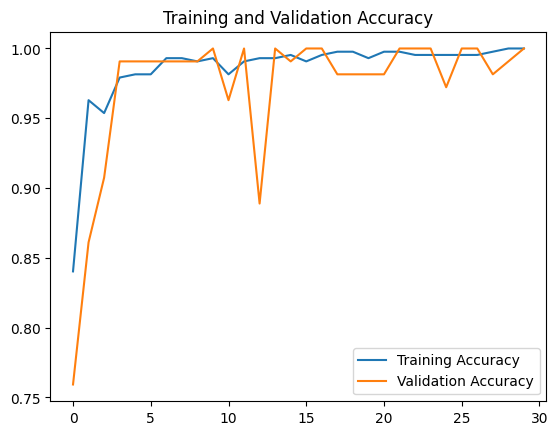

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/PsoriasisModel_EfficientNetV2B0_Improved_best_1.h5')
print("Model saved.")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

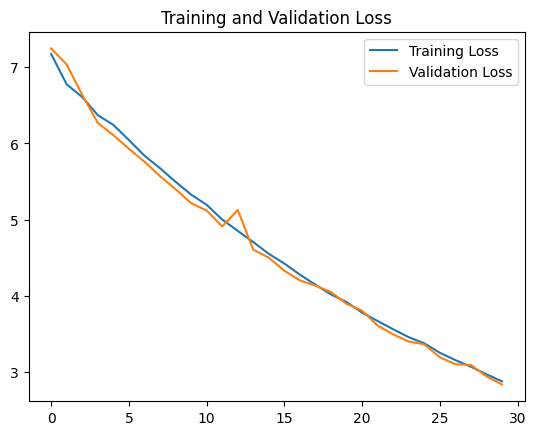

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

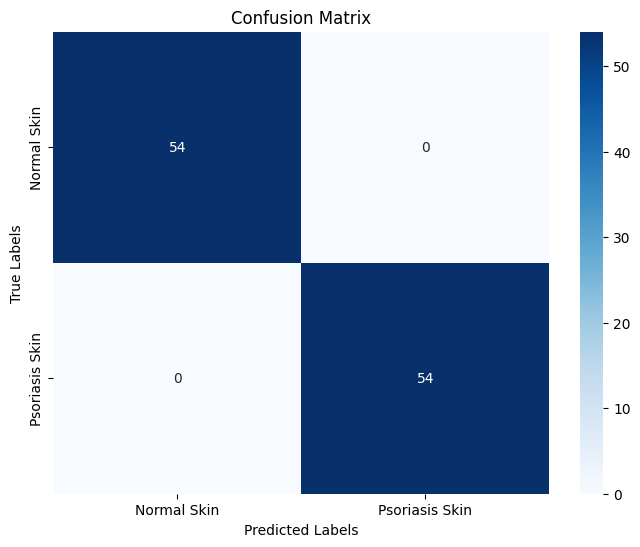

In [ ]:
# Import confusion matrix libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal Skin', 'Psoriasis Skin'], yticklabels=['Normal Skin', 'Psoriasis Skin'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


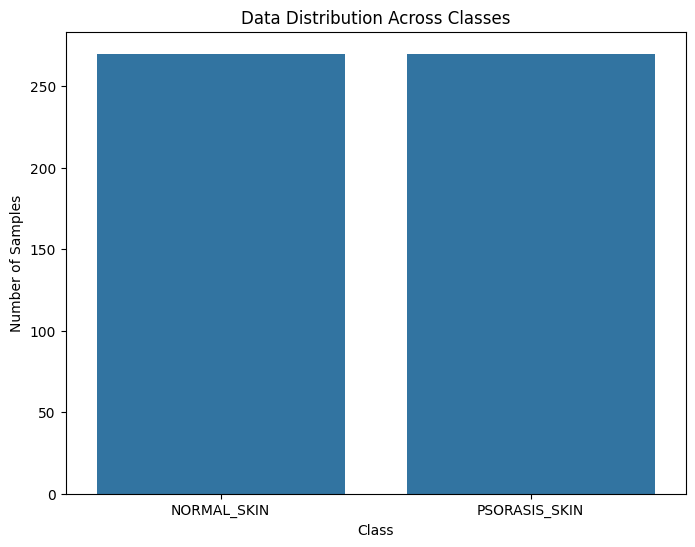

In [ ]:
# Visualize data distribution
import seaborn as sns

# Count the number of samples in each class
class_counts = np.bincount(y)
categories = ['NORMAL_SKIN', 'PSORASIS_SKIN']

# Plot the data distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=class_counts)
plt.title('Data Distribution Across Classes')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


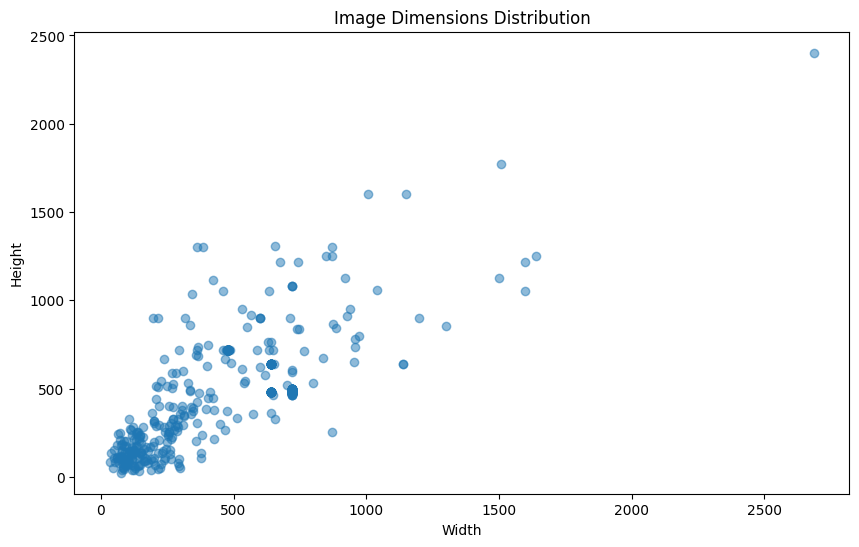

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Verify and correct the `dataset_path`**
dataset_path = '/content/drive/MyDrive/Data_Sets/Psoraisis_data/Psorasis_Detection'  # Assuming this is your dataset path

# Ensure the categories are correct and match the actual folder names
categories = ['NORMAL_SKIN', 'PSORASIS_SKIN']

# **Add error handling (optional but recommended)**
image_shapes = []
for cat in categories:
    category_path = os.path.join(dataset_path, cat)
    if os.path.exists(category_path):  # Check if the category folder exists
        for img in os.listdir(category_path):
            image_path = os.path.join(category_path, img)
            try:
                image_shapes.append(cv2.imread(image_path).shape[:2])
            except Exception as e:
                print(f"Error processing image: {image_path}. Error: {e}")
    else:
        print(f"Category folder not found: {category_path}")

image_shapes = np.array(image_shapes)


# Analyze image dimensions
image_shapes = [cv2.imread(os.path.join(dataset_path, cat, img)).shape[:2]
                for cat in categories
                for img in os.listdir(os.path.join(dataset_path, cat))]
image_shapes = np.array(image_shapes)

# Plot image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(image_shapes[:, 1], image_shapes[:, 0], alpha=0.5)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Dimensions Distribution')
plt.show()


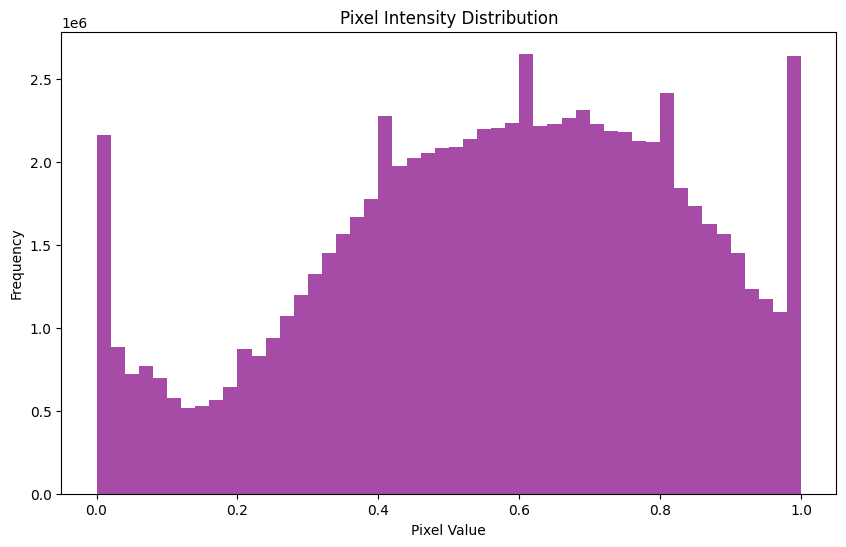

In [ ]:
# Flatten image data and plot pixel value histogram
pixel_values = X.flatten()

plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='purple', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


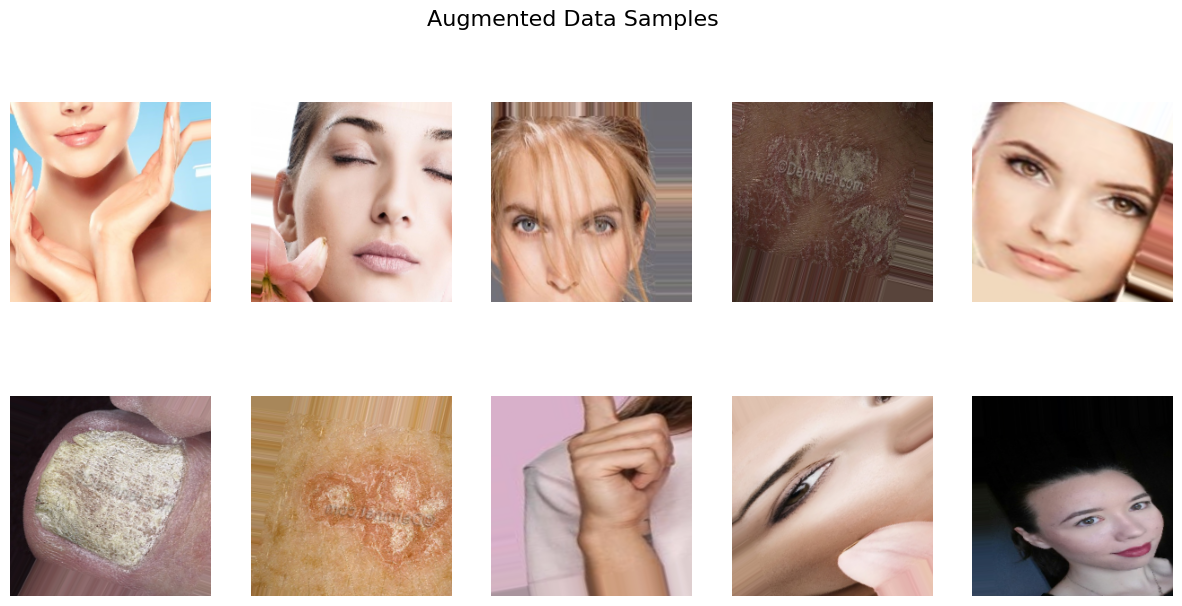

In [ ]:
# Visualize augmented data
augmented_images, _ = next(train_gen)  # Fetch one batch from the generator

plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle('Augmented Data Samples', fontsize=16)
plt.show()


customize

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
y_pred = np.argmax(model.predict(X_val), axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6840 - loss: 1.5794
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_val, y_pred, average='binary', zero_division=1)
recall = recall_score(y_val, y_pred, average='binary', zero_division=1)
f1 = f1_score(y_val, y_pred, average='binary', zero_division=1)

In [ ]:
# Print evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=['Normal Skin', 'Psoriasis Skin']))

Validation Loss: 1.5510879755020142
Validation Accuracy: 0.6944444179534912
Precision: 1.0
Recall: 0.3888888888888889
F1 Score: 0.56
Classification Report:
                 precision    recall  f1-score   support

   Normal Skin       0.62      1.00      0.77        54
Psoriasis Skin       1.00      0.39      0.56        54

      accuracy                           0.69       108
     macro avg       0.81      0.69      0.66       108
  weighted avg       0.81      0.69      0.66       108



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,009,042 (83.96 MB)

 Trainable params: 21,948,434 (83.73 MB)

 Non-trainable params: 60,608 (236.75 KB)